In [37]:
import sys; sys.path.insert(0,'C:/Users/shubh/Documents/Personal_work_stuff/program_files/')

In [282]:
from modules.requirements import *


In [291]:
class Construction_type_pred:
    def __init__(self,data_path,
                random_state,train_size,condition_,
                 char_sublinear_tf,char_strip_accents,char_analyzer,char_max_features,char_n_gram,
                 word_sublinear_tf,word_strip_accents,word_analyzer,word_max_features,word_n_gram,
                 regularization,reset_class1,reset_class2,reset_class3,reset_class4,reset_class5,reset_class6):
  
        ##Importing files
        self.data_path = data_path
        self.random_state = random_state
        self.condition_ = condition_
        self.train_size  = train_size
        #Vectorizer and model parameters
        
        self.char_sublinear_tf = char_sublinear_tf
        self.char_strip_accents = char_strip_accents
        self.char_analyzer=char_analyzer
        self.char_max_features = char_max_features
        self.char_n_gram=char_n_gram
        self.word_sublinear_tf = word_sublinear_tf
        self.word_strip_accents = word_strip_accents
        self.word_analyzer = word_analyzer
        self.word_max_features = word_max_features
        self.word_n_gram = word_n_gram
        self.regularization = regularization
        
        ###classwise threshold
        self.reset_class1=reset_class1
        self.reset_class2=reset_class2
        self.reset_class3=reset_class3
        self.reset_class4=reset_class4
        self.reset_class5=reset_class5
        self.reset_class6=reset_class6
        
  
    
    def import_files(self):
        """Importing required dataframe"""
        global data
        data=pd.read_csv(str(self.data_path),low_memory=self.condition_)
        print("****Importing completed")
        return data
        
    def Aggregation_manipulation(self,data):
        """Manipulating dataframe"""
        data=pd.read_csv('C:\\Users\\shubh\\Documents\\Personal_work_stuff\\data_files\\CC_usecase1.csv')
        data.columns=['Construction_description','Construction_code']
        data=data[data['Construction_code']!='Unknown']
        data.Construction_code=data.Construction_code.astype('str')
        data.Construction_code=data.Construction_code.convert_dtypes('categorical')
        data=data.reset_index()
        data=data.iloc[:,1:]
        
        print('****Aggregation and Manipulation Completed****')
        return data
    
    def Data_cleaning(self,data):
        """Cleaning string"""
        def cleaning(string):    
            string = str(string)
            string = string.lower()
            string = re.sub('\s\W',' ',string)
            string = re.sub('\W,\s',' ',string)
            string = re.sub(r'[^\w]', ' ', string)
            string = re.sub("\d+", "", string)
            string = re.sub('\s+',' ',string)
            string = re.sub('[!@#$_]', '', string)
            string = string.replace(",","")
            string = string.replace("[\w*"," ")
            string = re.sub(r'https?:\/\/.*[\r\n]*', '', string, flags=re.MULTILINE)
            string = re.sub(r'\<a href', ' ', string)
            string = re.sub(r'&amp;', '', string) 
            string = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', string)
            string = re.sub(r'[^\x00-\x7f]',r'',string) #removes arabic
            string = re.sub(r'<br />', ' ', string)
            string = re.sub(r'\'', ' ', string)
            string = string.lower()
            stop_words = set(stopwords.words('english'))  
            word_tokens = word_tokenize(string)  
            string = [w for w in word_tokens if not w in stop_words]
            
            string = ' '.join(i for i in string)
            string = re.findall('[a-z]{1,}',string)
            string = ' '.join(i for i in string)
            string = string.strip()
            return string
        print('****Cleaning Completed****')
        data.Construction_description = [cleaning(string) for string in data['Construction_description']]
        
        return data

    def Data_subset(self,dfa):
        """Splitting dataframe with stratifying sampling"""
        X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(data.Construction_description,
                                                    data.Construction_code, train_size=self.train_size,random_state=0, 
                                                     stratify=data.Construction_code)
        return X_train_tfidf,X_test_tfidf,y_train_tfidf,y_test_tfidf

        
    def FeatureEngineering_model_evaluation(self,X_train_tfidf,X_test_tfidf,y_train_tfidf,y_test_tfidf):
        """Feature engineering and model evaluation"""
        word_vectorizer = TfidfVectorizer(
            sublinear_tf=self.word_sublinear_tf,strip_accents=self.word_strip_accents,
            analyzer=self.word_analyzer,
            token_pattern=r'\w{1,}',
            ngram_range=self.word_n_gram,dtype=np.int32,
            max_features=self.word_max_features)
        char_vectorizer = TfidfVectorizer(
            sublinear_tf=self.char_sublinear_tf,strip_accents=self.char_strip_accents,
            analyzer=self.char_analyzer,
            ngram_range=self.char_n_gram,dtype=np.int32,
            max_features=self.char_max_features)
        
        tfidf = FeatureUnion([('char', char_vectorizer), ('word', word_vectorizer)])

        def class_weight(labels_dict,mu=0.15):
            total = sum(labels_dict.values())
            keys = labels_dict.keys()
            weight = dict()
            for i in keys:
                    score = np.log((mu)*(total)/float(labels_dict[i]))
                    weight[i] = score if score > 1 else 1
            return weight

        data['Construction_code']=data['Construction_code'].convert_dtypes('object')
        labels_dict = data['Construction_code'].value_counts().to_dict()
        weights = class_weight(labels_dict)
        # class_weight = class_weight.compute_class_weight('balanced',np.unique(data.Construction_code),data.Construction_code)
        # class_weight=dict(enumerate(class_weight.flatten(), 1)) 
        weights={'4': 1, '2': 1, '3': 1, '1': 1, '6': 1.1032320, '5': 1.1423795768519434}
        pipeline = Pipeline([('tfidf', tfidf), ('clf', LinearSVC(class_weight=weights))])
        
        
        pipeline.fit(X_train_tfidf,y_train_tfidf)
        tf_params = {
         'tfidf__word__max_features':[self.word_max_features],
         'tfidf__word__ngram_range': [self.word_n_gram],
         'tfidf__word__stop_words': [None, 'english'],
         'tfidf__char__max_features':[self.char_max_features],
         'tfidf__char__ngram_range': [self.char_n_gram],
         'tfidf__char__stop_words': [None, 'english'],
         'clf__C': [self.regularization]

        }


        clf = GridSearchCV(pipeline, param_grid=tf_params, cv = 15, verbose = 1, n_jobs = -1)
        clf.fit(X_train_tfidf, y_train_tfidf)


        y_true, y_pred = y_test_tfidf, clf.predict(X_test_tfidf)
        print('****Feature Engineering_model_evaluation Completed****')
        return data,y_pred,y_true,X_test_tfidf,clf
     
    def model_tuning(self,data,y_pred,y_true,X_test_tfidf,clf):
        """Model tuning and implementing nhi class for imbalance data"""
        
        def implement_confidence_score(dfa,ypred,y_test,X_test,model):
            dfa=dfa.loc[y_test.index.tolist(),]
            dfa['pred']=ypred.tolist()
            conf=[]
            for arr in model.decision_function(X_test):
                conf.append(np.max(arr))
            dfa['conf']=conf
            return dfa
        
        test_dfa=implement_confidence_score(data,y_pred,y_true,X_test_tfidf,clf)

        classes=['1','2','3','4','5','6']
        class_conf_range={}
        for i in classes:
            class_conf_range[i]=(test_dfa[test_dfa['Construction_code']==i]['conf'])

        class_conf_range_val={}
        for i,j in class_conf_range.items():
            print("Min thresold of ",i,round(np.min(class_conf_range[i]),4)," and Max thresold of ",i,round(np.max(class_conf_range[i]),4))
            class_conf_range_val[i]=round(np.min(class_conf_range[i]),4)
        def evaluate_nhi(df_test,classes_threshold):
            val_test=df_test

            def split_dfs(df,class_name):
                return df_test[df_test["Construction_code"]==class_name]




            df_test_1=split_dfs(df_test,"1")
            df_test_2=split_dfs(df_test,"2")
            df_test_3=split_dfs(df_test,"3")
            df_test_4=split_dfs(df_test,"4")
            df_test_5=split_dfs(df_test,"5")
            df_test_6=split_dfs(df_test,"6")


            def subset_acc_conf(df,threshold):
                return df[df['conf']>=threshold]

            one=classes_threshold[0]
            second=classes_threshold[1]
            third=classes_threshold[2]
            fourth=classes_threshold[3]
            fivth=classes_threshold[4]
            sixth=classes_threshold[5]

            df_test_filtered_0=subset_acc_conf(df_test_1,one)
            df_test_filtered_1=subset_acc_conf(df_test_2,second)
            df_test_filtered_2=subset_acc_conf(df_test_3,third)
            df_test_filtered_3=subset_acc_conf(df_test_4,fourth)
            df_test_filtered_4=subset_acc_conf(df_test_5,fivth)
            df_test_filtered_5=subset_acc_conf(df_test_6,sixth)

            df_test_filtered=pd.concat([df_test_filtered_0,df_test_filtered_1,df_test_filtered_2,df_test_filtered_3,df_test_filtered_4,df_test_filtered_5])

            print("NHI P",math.floor((val_test.shape[0]-df_test_filtered.shape[0])*100/val_test.shape[0]))
            cls=clf.classes_


            conf_mat = confusion_matrix(df_test_filtered['Construction_code'],  df_test_filtered['pred'])
            fig, ax = plt.subplots(figsize=(10,10))
            sns.heatmap(conf_mat, annot=True, fmt='d',xticklabels=cls, yticklabels=cls)
            plt.ylabel('Actual')
            plt.xlabel('Predicted')
            plt.show()
            print(metrics.classification_report(df_test_filtered['Construction_code'], df_test_filtered['pred']))
            
        
        zero_threshold=[class_conf_range_val['1']+self.reset_class1,class_conf_range_val['2']+self.reset_class2,
                        class_conf_range_val['3']+self.reset_class3,class_conf_range_val['4']+self.reset_class4,
                        class_conf_range_val['5']+self.reset_class5,class_conf_range_val['6']+self.reset_class6]
        evaluate_nhi(test_dfa,zero_threshold)
        print('****Model Tuning Completed****')
        



### Initializing the Construction type prediction class

In [284]:
class_p=Construction_type_pred('C:\\Users\\shubh\\Documents\\Personal_work_stuff\\data_files\\CC_usecase1.csv',
              45,0.70,True, #data param
              True,'unicode','char_wb',500,(1,3), #character level tfidf param
              True,'unicode','word',900,(1,4), #word level tfidf param
              1,###svc param
            0.8459,0.09,0,0,0.001,0) # class-wise threshold param

### Importing files 

In [285]:
data=class_p.import_files()

****Importing completed


### Data aggregation and manipulation 

In [286]:
data=class_p.Aggregation_manipulation(data)

****Aggregation and Manipulation Completed****


### Cleaning text 

In [287]:
data=class_p.Data_cleaning(data)

****Cleaning Completed****


### Splitting data (stratify)

In [292]:
X_train_tfidf,X_test_tfidf,y_train_tfidf,y_test_tfidf=class_p.Data_subset(data)

###  Feature engineering model and evaluation (imbalance handling)

In [289]:

data,y_pred,y_true,X_test_tfidf,clf=class_p.FeatureEngineering_model_evaluation(X_train_tfidf,X_test_tfidf,y_train_tfidf,y_test_tfidf)

Fitting 15 folds for each of 4 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


****Feature Engineering_model_evaluation Completed****


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    1.3s finished


### Modeling tuning and NHI 

Min thresold of  1 -0.6041  and Max thresold of  1 1.7727
Min thresold of  2 -0.4684  and Max thresold of  2 2.0018
Min thresold of  3 -0.3076  and Max thresold of  3 1.2043
Min thresold of  4 -0.3738  and Max thresold of  4 2.231
Min thresold of  5 -0.2703  and Max thresold of  5 1.5066
Min thresold of  6 -0.2497  and Max thresold of  6 1.6585
NHI P 4


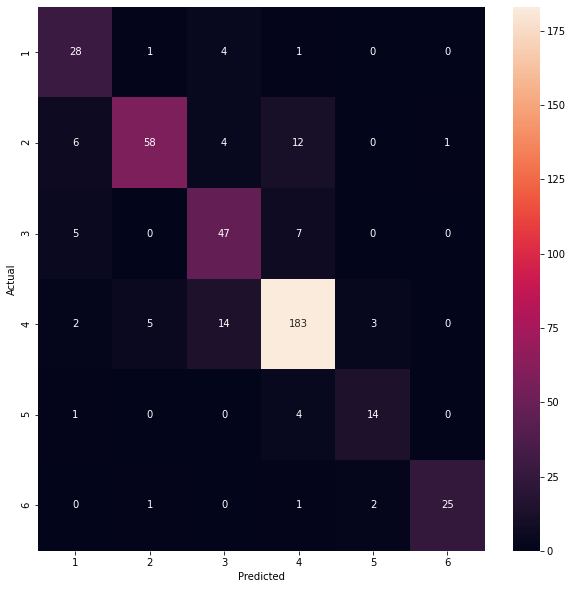

              precision    recall  f1-score   support

           1       0.67      0.82      0.74        34
           2       0.89      0.72      0.79        81
           3       0.68      0.80      0.73        59
           4       0.88      0.88      0.88       207
           5       0.74      0.74      0.74        19
           6       0.96      0.86      0.91        29

    accuracy                           0.83       429
   macro avg       0.80      0.80      0.80       429
weighted avg       0.84      0.83      0.83       429

****Model Tuning Completed****


In [290]:
class_p.model_tuning(data,y_pred,y_true,X_test_tfidf,clf)